<a href="https://colab.research.google.com/github/Cabir40/BrianTumotMultiClasification/blob/main/BrainTumorMulti_2_streamlit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
tf.__version__

'2.7.0'

In [ ]:
pwd

'/content'

In [ ]:
import os
import json

from google.colab import files
files.upload()


f = open('kaggle.json')
data = json.load(f)
os.environ['KAGGLE_USERNAME'] = data["username"] # username from the json file
os.environ['KAGGLE_KEY'] = data["key"] # key from the json file


!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json 
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset 

Saving kaggle.json to kaggle.json
 97% 144M/149M [00:00<00:00, 142MB/s]
100% 149M/149M [00:01<00:00, 148MB/s]


In [ ]:
!unzip \*.zip  && rm *.zip

In [ ]:
import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow.keras
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.losses import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [ ]:
train_dir =  '/content/Training/'
train_paths = []
for label in os.listdir(train_dir):
    for file in os.listdir(train_dir+label):
        train_paths.append(train_dir+label+'/'+file)
random.shuffle(train_paths)
# show an example of the list
print(train_paths[0])

/content/Training/pituitary/Tr-pi_0396.jpg


In [ ]:
test_dir = '/content/Testing/'
test_paths = []
for label in os.listdir(test_dir):
    for file in os.listdir(test_dir+label):
        test_paths.append(test_dir+label+'/'+file)
random.shuffle(test_paths)
# show an example of the list
print(test_paths[0])

/content/Testing/glioma/Te-gl_0126.jpg


In [ ]:
labels = os.listdir(train_dir)
labels

['pituitary', 'notumor', 'meningioma', 'glioma']

In [ ]:
def open_images(paths):
    '''
    Opens a batch of images, given the image path(s) as a list
    '''
    images = []
    for path in paths:
        image = load_img(path, target_size=(128,128))
        image = np.array(image)/255.0
        images.append(image)
    return np.array(images)

In [ ]:
def get_labels(paths):
    '''
    it is possible to get the label from the path, just split the path by "/" and index -2
    For example, /kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_1020.jpg
    splitting by "/" gives ['kaggle','input','brain-tumor-mri-dataset','Training','pituitary','Tr-pi_1020.jpg']
    Now indexing -2 gives "pituitary"
    '''
    label = []
    for path in paths:
        path = path.split('/')[-2]
        label.append(labels.index(path))
    return label

In [ ]:
def data_gen(data_paths, batch_size=1):
    img=[]
    lab=[]
    for i in range(0, len(data_paths), batch_size):
        paths = data_paths[i:i+batch_size]
        images = open_images(paths)
        img.append(open_images(paths).reshape(128, 128, 3))
        labels = get_labels(paths)
        lab.append(get_labels(paths))
        
        #yield images,np.array(labels)
    return np.array(img) , np.array(lab)

pituitary


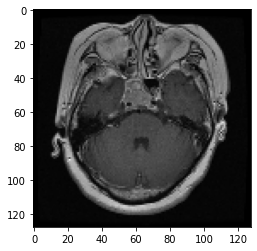

In [ ]:
i = random.randint(0,len(train_paths))
label = train_paths[i].split('/')[-2] # This is how we get the label from the path train_paths[i]
image = open_images([train_paths[i]])
print(label)
plt.imshow(image[0])
plt.show()

In [ ]:
model = Sequential()

model.add(Conv2D(64,(7,7), input_shape=(128, 128, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128,(7,7), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

# Convolutional layer 3
model.add(Conv2D(128,(7,7), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

# Convolutional layer 4
model.add(Conv2D(256,(7,7), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

 # Convolutional layer 5
model.add(Conv2D(256,(7,7), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

# Convolutional layer 6
model.add(Conv2D(512,(7,7), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(units= 1024, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(units=512, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(units=4, activation='softmax'))

# model.summary()

# model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy',metrics=['sparse_categorical_accuracy'])

model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy',metrics=['sparse_categorical_accuracy'])

In [ ]:
model_es = EarlyStopping(monitor = 'loss', min_delta = 1e-6, patience = 6, verbose = 1)
model_rlr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 6, verbose =1)
model_mcp = ModelCheckpoint(filepath = 'model_BEST.h5', monitor = 'sparse_categorical_accuracy', save_best_only = True, verbose = 1)

In [ ]:
X_train, y_train = data_gen(train_paths)
X_test, y_test = data_gen(test_paths)

In [ ]:
history = model.fit(X_train, y_train,               steps_per_epoch=len(X_train)//32, 
                    epochs=30, 
                    validation_data=(X_test, y_test), validation_steps= len(X_test)//32,
                    callbacks=[model_es, model_rlr, model_mcp])

Epoch 1/3
178/178 [==============================] - ETA: 0s - loss: 0.6625 - sparse_categorical_accuracy: 0.7582
Epoch 00001: sparse_categorical_accuracy improved from -inf to 0.75821, saving model to model_BEST.h5
178/178 [==============================] - 65s 291ms/step - loss: 0.6625 - sparse_categorical_accuracy: 0.7582 - val_loss: 2.1423 - val_sparse_categorical_accuracy: 0.3105 - lr: 1.0000e-04
Epoch 2/3
178/178 [==============================] - ETA: 0s - loss: 0.3796 - sparse_categorical_accuracy: 0.8631
Epoch 00002: sparse_categorical_accuracy improved from 0.75821 to 0.86311, saving model to model_BEST.h5
178/178 [==============================] - 49s 273ms/step - loss: 0.3796 - sparse_categorical_accuracy: 0.8631 - val_loss: 1.7214 - val_sparse_categorical_accuracy: 0.3631 - lr: 1.0000e-04
Epoch 3/3
121/178 [===================>..........] - ETA: 14s - loss: 0.2524 - sparse_categorical_accuracy: 0.9056

In [ ]:
model.evaluate(X_test, y_test, steps=len(X_test)//32)

Predicted: meningioma
Actual: glioma
            probablity
pituitary     0.055473
notumor       0.014371
meningioma    0.648740
glioma        0.281416


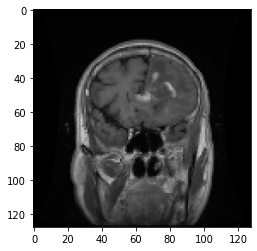

In [27]:
import pandas as pd
i = random.randint(0,len(test_paths))
images = open_images([test_paths[i]])
predicted = model.predict(images)[0]
predicted = np.argmax(predicted)
predicted = labels[predicted]
prob = model.predict(images)[0].round(6)

label = test_paths[i].split('/')[-2]
plt.imshow(images[0])
print('Predicted:', predicted)
print('Actual:', label)
print(pd.DataFrame(index = labels,data= prob,columns=["probablity"]))

In [28]:
from sklearn.metrics import classification_report, confusion_matrix

y_predicted = np.argmax(model.predict(X_test),axis=1).reshape(-1,1)

print(classification_report(y_test, y_predicted))

print(confusion_matrix(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.75      0.99      0.85       300
           1       0.91      0.88      0.89       405
           2       0.75      0.56      0.64       306
           3       0.82      0.80      0.81       300

    accuracy                           0.81      1311
   macro avg       0.80      0.81      0.80      1311
weighted avg       0.81      0.81      0.80      1311

[[297   2   1   0]
 [ 25 356  18   6]
 [ 58  31 170  47]
 [ 18   3  39 240]]


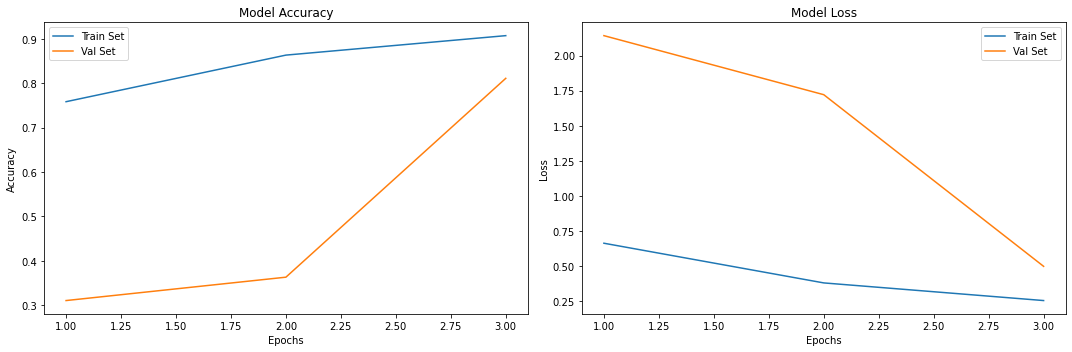

In [29]:
acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

In [30]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    import itertools
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

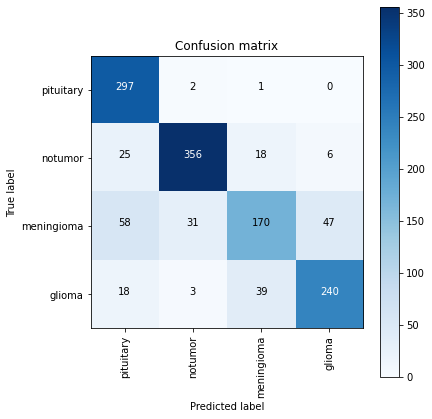

In [31]:
confusion_mtx = confusion_matrix(y_test, y_predicted)
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels), normalize=False)

In [ ]:
# model.save('model_best.h5')

In [32]:
! pip install streamlit -q
! pip install npx -q
! pip install pyngrok -q

     |████████████████████████████████| 9.1 MB 4.8 MB/s 
     |████████████████████████████████| 4.3 MB 30.5 MB/s 
     |████████████████████████████████| 180 kB 41.2 MB/s 
     |████████████████████████████████| 111 kB 46.6 MB/s 
     |████████████████████████████████| 76 kB 4.4 MB/s 
     |████████████████████████████████| 178 kB 43.1 MB/s 
     |████████████████████████████████| 63 kB 1.6 MB/s 
     |████████████████████████████████| 126 kB 41.2 MB/s 
     |████████████████████████████████| 791 kB 43.7 MB/s 
     |████████████████████████████████| 374 kB 47.7 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyter-console 5.2.0 requires prompt-toolkit<2.0.0,>=1.0.0, but you have prompt-toolkit 3.0.24 which is incompatible.
google-colab 1.0.0 requires ipykernel~=4.10, but you have ipykernel 6.6.0 which is incompatible.
google-colab 1.0.0 requires ipytho

In [50]:
%%writefile app.py

import json
import os
import streamlit as st
import pandas as pd
import base64
import functools 
import numpy as np
from scipy import spatial

import warnings
warnings.filterwarnings('ignore')

st.sidebar.image('https://eski.ahievran.edu.tr/images/haberler/basin/logomuz/ahievran_logo_210518.png', width=256)

HTML_WRAPPER = """<div style="overflow-x: auto; border: 1px solid #e6e9ef; border-radius: 0.5rem; padding: 0.5rem; margin-bottom: 0.5rem">{}</div>"""

st.title("AhiHub Prediction Playground")


PIPELINES = ['Brain Tumor Detection DL',
             'EKG Apne Detection DL',
             'Stock Price Prection DL',
             'NLP Social Media Sentiment Analysis',
             'other']

BrainTumorList = ['BinaryDetection',
                  'MultiClassification',
                  'ner_jsl',
                  'ner_bionlp']

                 

     

st.sidebar.header('Choose Prediction Model')
st.sidebar.write('')

pipe_type = st.sidebar.selectbox('Select Prediction Type',PIPELINES)

if pipe_type == 'Brain Tumor Detection DL':
  nerModelType = st.sidebar.selectbox("Select MedicalNerModel", (BrainTumorList))



elif pipe_type == 'EKG Apne Detection DL':

  nerModelType = st.sidebar.selectbox("Select MedicalNerModel",(BrainTumorList))
  st.sidebar.write('')





            

elif pipe_type == 'Stock Price Prection DL':
  nerModelType = st.sidebar.selectbox("Select MedicalNerModel",(BrainTumorList))
  st.sidebar.write('')




elif pipe_type == 'NLP Social Media Sentiment Analysis':
  nerModelType = st.sidebar.selectbox("Select MedicalNerModel",(BrainTumorList))
  st.sidebar.write('')



else:
  st.sidebar.write('We are working new Pipeline Types')
  st.sidebar.write('')
  pipeline = None


TEXT = ['A 28-year-old female with a history of gestational diabetes mellitus diagnosed eight years prior to presentation and subsequent type two diabetes mellitus ( T2DM ), one prior episode of HTG-induced pancreatitis three years prior to presentation , associated with an acute hepatitis , and obesity with a body mass index ( BMI ) of 33.5 kg/m2 , presented with a one-week history of polyuria , polydipsia , poor appetite , and vomiting. The patient was prescribed 1 capsule of Advil 10 mg for 5 days and magnesium hydroxide 100mg/1ml suspension PO. He was seen by the endocrinology service and she was discharged on 40 units of insulin glargine at night , 12 units of insulin lispro with meals , and metformin 1000 mg two times a day .',
        'The patient was prescribed 1 unit of Advil for 5 days after meals. The patient was also given 1 unit of Metformin daily. He was seen by the endocrinology service and she was discharged on 40 units of insulin glargine at night , 12 units of insulin lispro with meals , and metformin 1000 mg two times a day.',
        'I experienced fatigue, muscle cramps, anxiety, agression and sadness after taking Lipitor but no more adverse after passing Zocor.',
        'CustomText']

textType = st.selectbox("Select TEXT",(TEXT))

if textType != "CustomText":
  ner_text = textType
  st.write('NER Input Text',textType)
else:
  ner_text = st.text_area('NER Input Text', 'Please type here your text.')

    


Overwriting app.py


In [51]:
!streamlit run app.py & npx localtunnel --port 8501

npx: installed 22 in 2.775s
your url is: https://black-bear-12.loca.lt

  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.2:8501
  External URL: http://35.222.225.186:8501

  Stopping...
^C


In [36]:
!streamlit run app.py&>/dev/null&

import time

time.sleep(3)

from pyngrok import ngrok

public_url = ngrok.connect(addr='8501')

print (public_url)

KeyboardInterrupt: ignored

In [ ]:
!killall ngrok